# Motivation For Feature Engineering

With the features provide in the data, we are not getting the preformance that we would desire.  In [a previous study](https://www.researchgate.net/publication/273762860_Coral_reef_benthic_regimes_exhibit_non-linear_threshold_responses_to_natural_physical_drivers), authors studied similar predictors on coral reef regimes exhibited non-linear responses to the predictors. Both the author of the original paper and this paper used boosted regression trees to obtain these non-linear predictors, but we are not using this model as it was not gone over in class and we wanted to try something new. The results of "Parsing human and biophysical drivers
of coral reef regimes" did output some analysis of the non-linearities, but we ignored this analysis as it was run on the same data that we are using in our model, so we did not want to introduce test data leakage into the model.  Therefore, we aim to take the findings about predictors of a seperate dataset in Palmyra Atoll to help us create better features for our prediction of regimes. We lack enough domain expertise to bin features or do transformations on individual features. However, there are some features where we could envision interaction terms.  We construct them and give justification in the following sections.

## Wave Power, Complexity, and Depth

In [a previous study](https://www.researchgate.net/publication/273762860_Coral_reef_benthic_regimes_exhibit_non-linear_threshold_responses_to_natural_physical_drivers), the authors highlighted the impact of wave-induced stress on the coral reef. Therefore, we decided to add some interaction terms we think would be plausible. Here are some definition of existing predictors in our dataset which will help to understand the interactions:

* `WAV_CLIM_M` is the  "maximum monthly climatological mean of wave power (kW m^{-1})" which ranges from (0.886858, 114.938387) 
* `Complexity` is the "topographical complexity of the seafloor measured as slope of slope (i.e. the maximum rate of change in seafloor slope)"  and ranges from  (0 to 35.86)
* `Depth` is the  "depth of the seafloor in metres" which ranges from (0.487680, 30)

We create `sqrt(WAV_CLIM_M*Complexity)` which will potentially allow us to capture a muliplicative interaction between the wave power and incline of the seafloor which may be a proxy for wave stress on the coral reef. We square root it as teh quantile of initial creation of this column exploded quite fast.  Therefore, we wanted to do a squareroot transform to have them more uniformly spaced out. 

Likewise,`log(WAV_CLIM_M/Depth)` would be large for more wave power on shallower reefs which is another proxy for wave stress. It had a heavy tail and skew so we took a log transform. 

Finally, we add `Complexity/Depth` as another interaction term which may add more flexibility to our model to pick out regimes.  This feature takes into account the depth when measuring complexity of the reef.  The hypothesis for including this feature would be that complexity is more important when the reef is shallower. 


In [29]:
from Notebook_helpers.load_data import *
import numpy as np
import pandas as pd
df, _, _, _ = load_coral_data(complete=True, CV=False, convert_to_categorical=True)
df['sqrt_power_x_compexity'] = np.sqrt(df['WAV_CLIM_M']*(df['Complexity']+1))
df['log_power_over_depth'] = np.log(df['WAV_CLIM_M']/df['Depth'])
df['complexity_over_depth'] = (df['Complexity']+1)/df['Depth']

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a1c4750b8>,
      dtype=object)

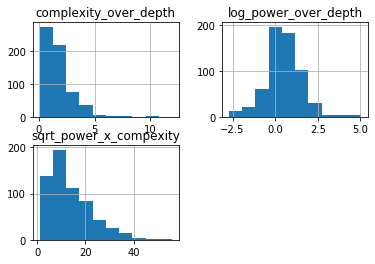

In [30]:
# Visualize histograms of new variables
df[['sqrt_power_x_compexity', 'log_power_over_depth', 'complexity_over_depth']].hist()

## Algae and Irradiance

Another interaction could be with invasive algae and irradiance. Given algae need sunlight to grow, there could be an interaction between a high amount of irradiance and invasive algae species in tranforming into a different regime. The relevant columns are: 

* `Invasive_Algae` which is an indicator of "observed presence of any invasive algae"
* `PAR_CLIM_M` which is "maximum monthly climatological mean of photosynthetically available radiation"

So we create a new column `Irradiance_x_inv_algae` which is the product of the two.

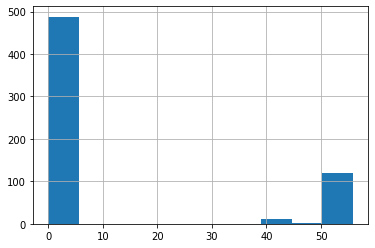

In [47]:
df['Irradiance_x_inv_algae'] = df['Invasive_Algae'].astype(np.int8)*df['PAR_CLIM_M']
df['Irradiance_x_inv_algae'].hist()

## Anomolous Events

`wave_anomaly` annual average of the total number of anomalous
events for wave power

`chlorophyll_anomaly` annual average of the total number of anomalous
events for chlorophyll-a


Potentially the combination of anomolous events could be a multiplicative interaction. We think that anomolies could be a compounding effect, so we create an interaction with 

`both_anomolies` = `wave_anomaly` * `chlorophyll_anomaly` 


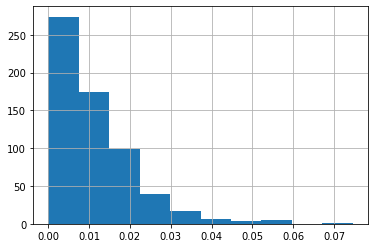

In [51]:
df['both_anomolies'] = df['WAV_ANOM_F']*df['CHL_ANOM_F']
df['both_anomolies'].hist()

# Conclusion

This analysis was done through insights about the domain rather than artificially creating numorous features and using feature selecion to par down the number of features. We added 5 additional interaction terms